In [88]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
from library.Tempotron import Tempotron
from library.comput_utils import acc_metrics
from library.script_wrappers import find_nidx_along_traj, datagen_jitter
from library.utils import save_pickle, load_pickle
from library.visualization import customlegend
from library.script_wrappers import directional_acc_metrics

In [89]:
# Plotting and path parameters
legendsize = 8
plt.rcParams.update({"font.family": "Arial",
                     'font.size': legendsize,
                     "axes.titlesize": legendsize,
                     'axes.labelpad': 0,
                     'axes.titlepad': 0,
                     'xtick.major.pad': 0,
                     'ytick.major.pad': 0,
                     'lines.linewidth': 1,
                     'figure.figsize': (5.2, 5.5),
                     'figure.facecolor': 'white',
                     'figure.dpi': 300,
                     'axes.spines.top': False,
                     'axes.spines.right': False,

                     })

project_tag = 'Jit100_2ms_gau'
simdata_dir = 'sim_results/fig6_TrainStand_Icompen2'
data_dir = join(simdata_dir, project_tag)
plot_dir = 'plots/fig6'
os.makedirs(plot_dir, exist_ok=True)

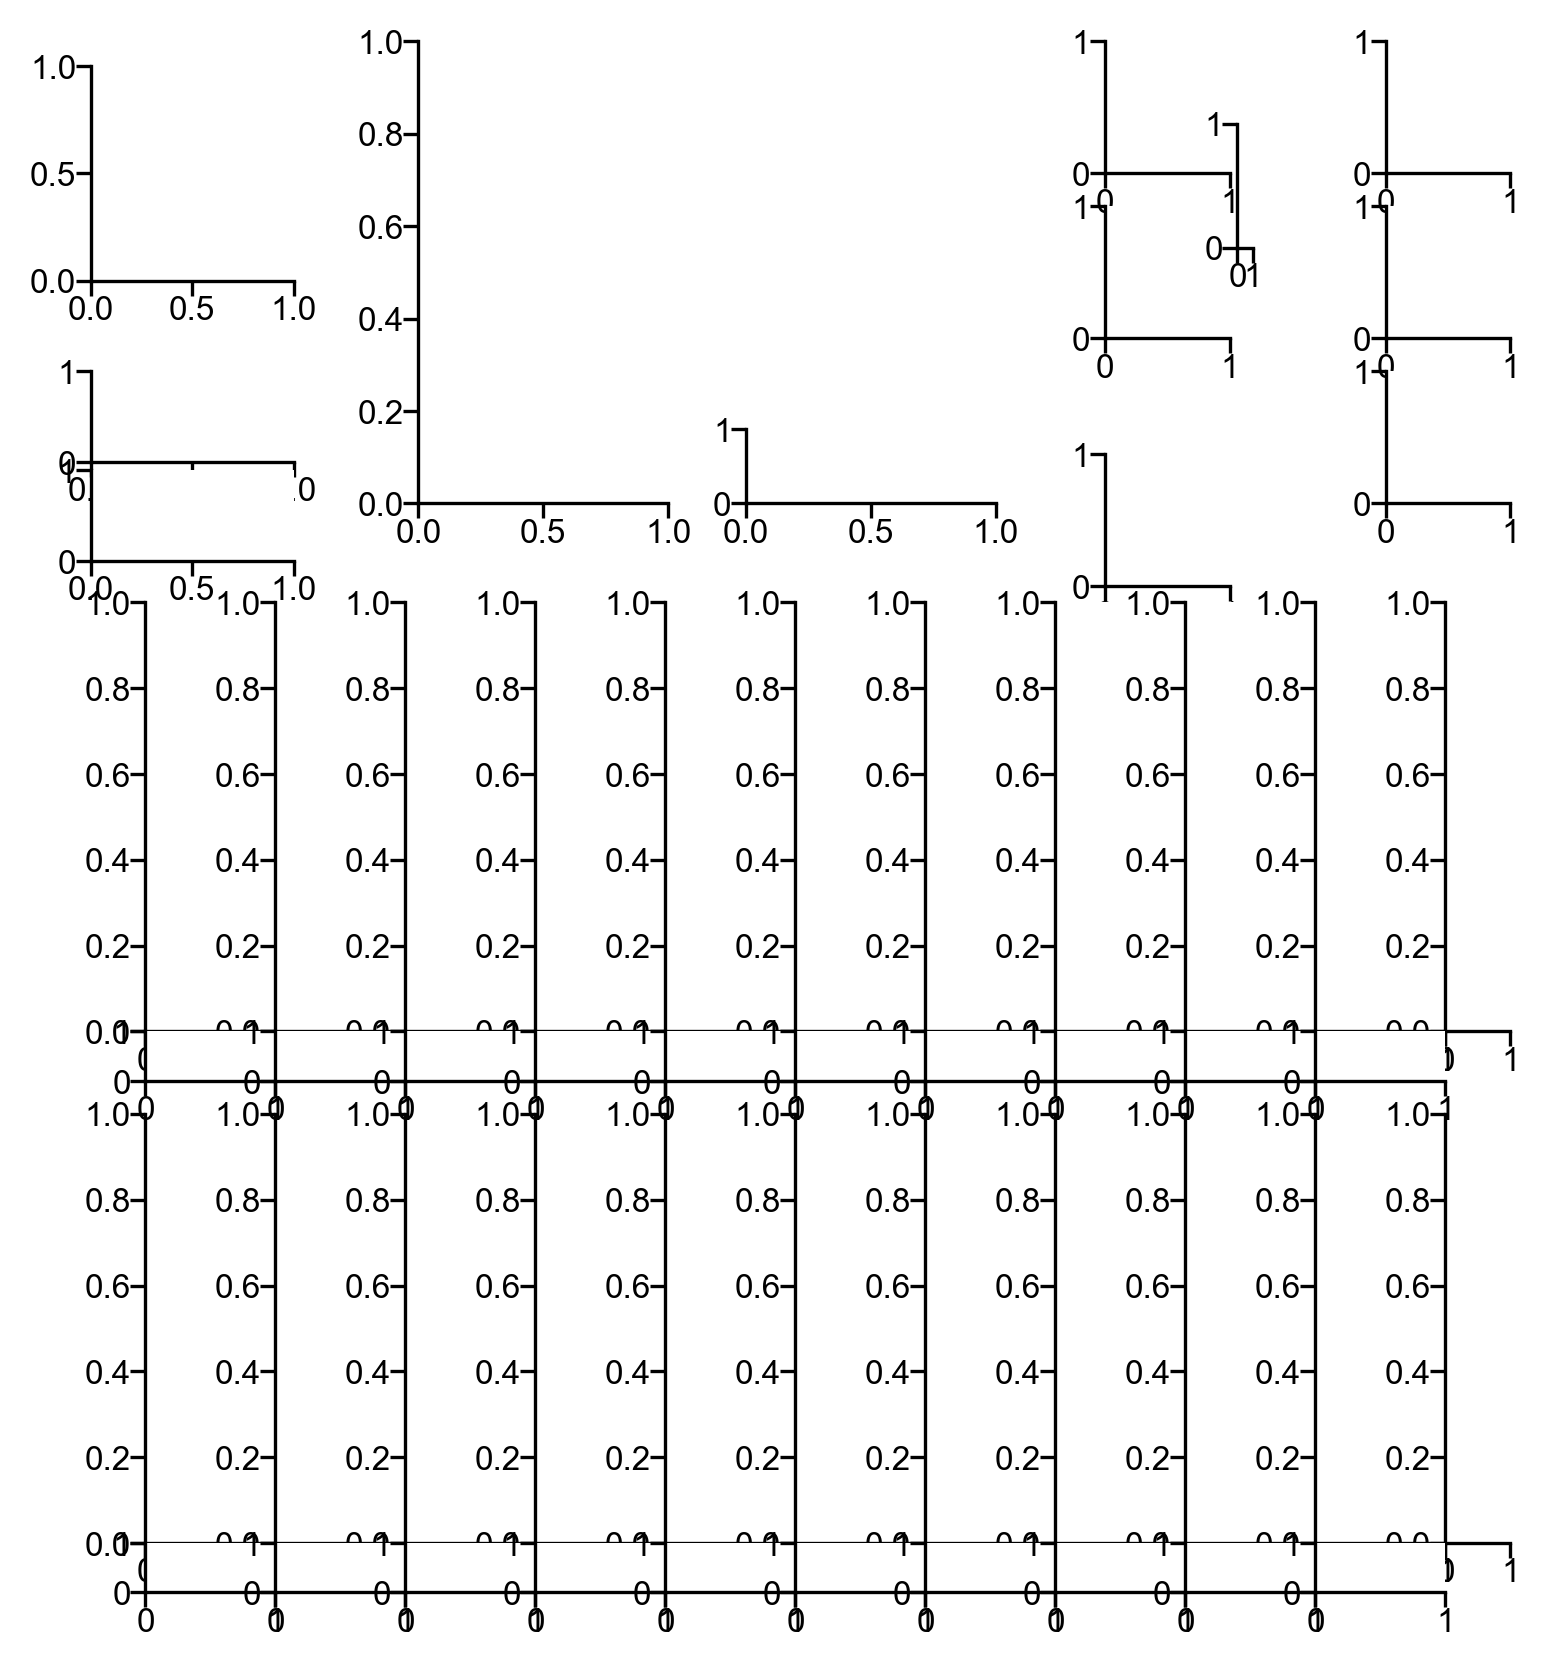

In [90]:
# # For widths:  0.75/5 | Tempotron illustration 2.75/5 | 0.75/5 | 0.75/5
# Top 1st column: Training scheme
ax_h1 = 0.75/5
ax_w1 = 0.75/5
hgap1 = 0.02
wgap1 = 0.02
xshift1 = 0.055
yshift1 = -0.015
inseq_yshift = -0.035
exseq_yshift = -0.02

# Top 2nd column: Tempotron illustration
axtem_w = 1.3/5  # The next half 1.375 is for drawing
tem_xshift = 0.02
tem_yshift = 0
tem_hgap = 0.02
tem_wgap = 0.1
trace_xshift = -0.05


# Top 3rd & 4th column: 2D weights, testing scheme and ACC
hgap3 = 0
wgap3 = 0.02
ax_h3 = 0.5/5   # To ensure square shape
ax_w3 = 0.5/5
xshift3 = -0.02
yshift3_12 = 0.01
yshift3_3 = -0.04
xshift4 = 0.06
yshift4 = 0.01

# Raster plots
ax_h_ras = 1.75/5
ax_w_ras = 1/12  # 0.5/10.5 for 1d weights
hgap_ras = 0.06
ras_xshift = 0.1
ras_in_yshift = -0.02
ras_ex_yshift = 0.02

# Child plots in the raster plots
trace_h = 0.03
trace_hshift = 0.03
w1d_w = 0.5/12

fig = plt.figure()
ax_trainScheme = fig.add_axes([ax_w1 * 0 + wgap1/2 + xshift1, 1 - ax_h1 * 1 + hgap1/2 + yshift1, ax_w1 - wgap1, ax_h1 - hgap1])
ax_trainSeqIn = fig.add_axes([ax_w1 * 0 + wgap1/2 + xshift1, 1 - ax_h1 * 1.5 + hgap1/2 + yshift1 + inseq_yshift, ax_w1 - wgap1, ax_h1/2 - hgap1])
ax_trainSeqEx = fig.add_axes([ax_w1 * 0 + wgap1/2 + xshift1, 1 - ax_h1 * 2.0 + hgap1/2 + yshift1 + exseq_yshift, ax_w1 - wgap1, ax_h1/2 - hgap1])

ax_tem   = fig.add_axes([ax_w1 * 1 + tem_wgap/2 + xshift1 + tem_xshift          , 1 - ax_h1 * 2 + tem_hgap/2 + tem_yshift, axtem_w - tem_wgap, ax_h1*2 - tem_hgap])
ax_trace = fig.add_axes([ax_w1 * 1 + axtem_w + tem_wgap/2 + xshift1 + tem_xshift + trace_xshift, 1 - ax_h1 * 2 + tem_hgap/2 + tem_yshift, axtem_w - tem_wgap, ax_h1*0.3])

axW_x = ax_w1 + xshift1 + axtem_w * 2
ax_inW2D = fig.add_axes([axW_x + wgap3/2 + xshift3, 1 - ax_h3 * 1 + hgap3/2 + yshift3_12, ax_w3 - wgap3, ax_h3 - hgap3 - wgap3])
ax_exW2D = fig.add_axes([axW_x + wgap3/2 + xshift3, 1 - ax_h3 * 2 + hgap3/2 + yshift3_12, ax_w3 - wgap3, ax_h3 - hgap3 - wgap3])
ax_testScheme = fig.add_axes([axW_x + wgap3/2 + xshift3, 1 - ax_h3 * 3 + hgap3/2 + yshift3_3, ax_w3 - wgap3, ax_h3 - hgap3 - wgap3])
ax_cbar = fig.add_axes([0.80, 0.865, 0.01, 0.075])

ax_acc = fig.add_axes([axW_x + ax_w3 + wgap3/2 + xshift4, 1 - ax_h3 * 1 + hgap3/2 + yshift4, ax_w3 - wgap3, ax_h3 - hgap3 - wgap3])
ax_tpr = fig.add_axes([axW_x + ax_w3 + wgap3/2 + xshift4, 1 - ax_h3 * 2 + hgap3/2 + yshift4, ax_w3 - wgap3, ax_h3 - hgap3 - wgap3])
ax_tnr = fig.add_axes([axW_x + ax_w3 + wgap3/2 + xshift4, 1 - ax_h3 * 3 + hgap3/2 + yshift4, ax_w3 - wgap3, ax_h3 - hgap3 - wgap3])


ax_inRas180 = [fig.add_axes([ax_w_ras * i + ras_xshift, 1 - ax_h1*2 - ax_h_ras * 1 + trace_h + hgap_ras/2 + ras_in_yshift, ax_w_ras, ax_h_ras - hgap_ras - trace_h]) for i in range(10)]
ax_exRas180 = [fig.add_axes([ax_w_ras * i + ras_xshift, 1 - ax_h1*2 - ax_h_ras * 2 + trace_h + hgap_ras/2 + ras_ex_yshift, ax_w_ras, ax_h_ras - hgap_ras - trace_h]) for i in range(10)]

ax_inRasW1d = fig.add_axes([ax_w_ras * 10 + ras_xshift, 1 - ax_h1*2 - ax_h_ras * 1 + trace_h + hgap_ras/2 + ras_in_yshift, w1d_w, ax_h_ras - hgap_ras - trace_h])
ax_exRasW1d = fig.add_axes([ax_w_ras * 10 + ras_xshift, 1 - ax_h1*2 - ax_h_ras * 2 + trace_h + hgap_ras/2 + ras_ex_yshift, w1d_w, ax_h_ras - hgap_ras - trace_h])

ax_inRasTrace = [fig.add_axes([ax_w_ras * i + ras_xshift, 1 - ax_h1*2 - ax_h_ras * 1 + trace_hshift + ras_in_yshift, ax_w_ras, trace_h]) for i in range(10)]
ax_exRasTrace = [fig.add_axes([ax_w_ras * i + ras_xshift, 1 - ax_h1*2 - ax_h_ras * 2 + trace_hshift + ras_ex_yshift, ax_w_ras, trace_h]) for i in range(10)]


ax_exinW2D = [ax_exW2D, ax_inW2D]
ax_exinRas = [ax_exRas180, ax_inRas180]
ax_exinRasTrace = [ax_exRasTrace, ax_inRasTrace]
ax_exinRasW1d = [ax_exRasW1d, ax_inRasW1d]
ax_exinSeq = [ax_trainSeqEx, ax_trainSeqIn]
# plt.close(fig)

In [91]:
def plot_tempotron_traces(axRas, axTrace, axW1d, N, X, Y, Y_pred, temNw, all_nidx, yytun1d, kout_all, tspout_all, val2cmap, traj_deg, exintag):

    M = len(axRas)
    w_yax = np.arange(N)
    y_nidx = yytun1d[all_nidx[w_yax]]

    if exintag == 'in':

        ylim = (np.max(np.where(y_nidx <14.7)[0]), np.min(np.where(y_nidx > 25.8)[0]))
    else:
        ylim = (np.max(np.where(y_nidx <-24.8)[0]), np.min(np.where(y_nidx > -14.7)[0]))

    for Mi in range(M):

        for Ni in range(N):
            tsp = X[Mi, Ni]
            axRas[Mi].scatter(tsp, [Ni]*tsp.shape[0], marker='|', s=0.5, linewidths=0.5, color=val2cmap.to_rgba(temNw[Ni]))

        ysep_NiList = np.arange(0, 400, 20).astype(int)
        ysep_ax = np.arange(0, 400, 20) - 0.5
        for ysep in ysep_ax:
            axRas[Mi].axhline(ysep, color='gray', lw=0.5)
        axRas[Mi].set_yticks(ysep_NiList + 10)
        axRas[Mi].set_xlim(0, 100)
        axRas[Mi].set_xticks([])
        axRas[Mi].set_yticklabels(np.around(yytun1d[all_nidx[ysep_NiList + 10]], 0).astype(int).astype(str))
        axRas[Mi].set_ylim(ylim[0], ylim[1])
        if Y[Mi]:
            axRas[Mi].set_facecolor('0.9')
            axTrace[Mi].set_facecolor('0.9')
        if Mi > 0:
            axRas[Mi].set_yticks([])
        if Mi == 0:
            axRas[Mi].set_ylabel('y (cm)')

        # Plot voltage trace
        axTrace[Mi].plot(temN_tax, kout_all[Mi], color='gray')
        if tspout_all[Mi].shape[0] > 0:
            axTrace[Mi].eventplot([tspout_all[Mi][0]], lineoffsets=2.2, linelengths=0.2, linewidths=2, color='r')
        axTrace[Mi].set_xlim(0, 100)
        axTrace[Mi].set_xticks([0, 100])
        if exintag == 'ex':
            axTrace[Mi].set_xticklabels([100*Mi, 100*(Mi+1)])
        else:
            axTrace[Mi].set_xticklabels([])
        axTrace[Mi].set_ylim(0.1, 3)
        axTrace[Mi].axhline(Vthresh, color='k', linewidth=0.1)
        axTrace[Mi].set_yticks([])
        axTrace[Mi].spines.left.set_visible(False)
        if Mi > 0:
            axTrace[Mi].set_yticks([])

        # Plot flattened weights
        axW1d.barh(w_yax, temNw, color=val2cmap.to_rgba(temNw))
        axW1d.axvline(0, color='gray')
        axW1d.set_yticks(np.around(np.arange(N), 2))
        axW1d.axis('off')
        axW1d.set_ylim(ylim[0], ylim[1])


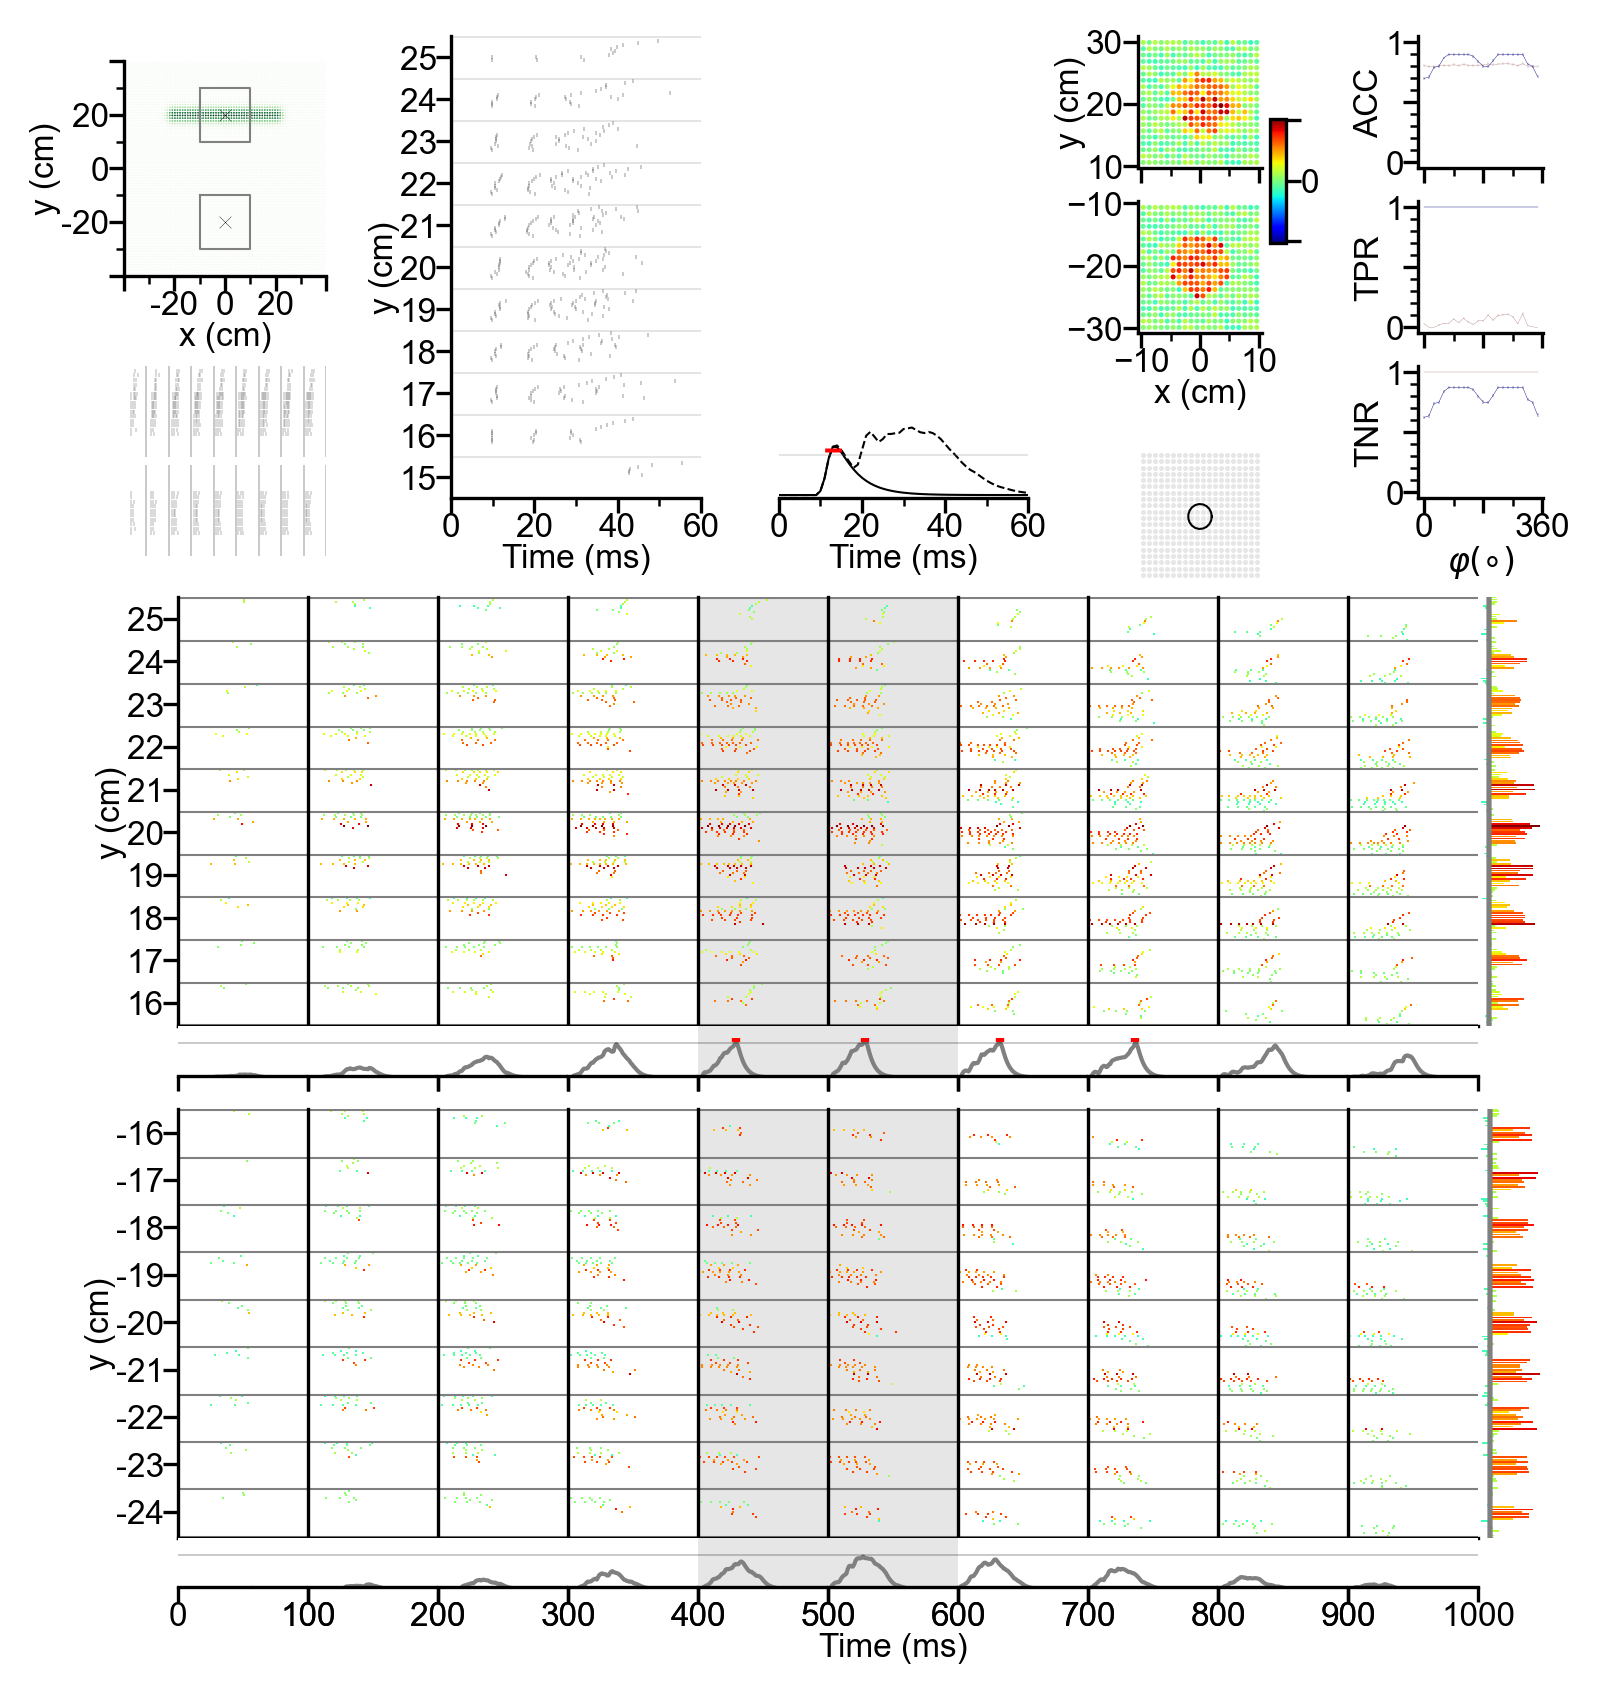

In [92]:
# # Determine weight color scale
all_temNw = np.concatenate([np.load(join(data_dir, 'w_%s_ex.npy'%(project_tag))), np.load(join(data_dir, 'w_%s_in.npy'%(project_tag)))])
wmin, wmax = all_temNw.min(), all_temNw.max()
abswmax = max(np.abs(wmin), np.abs(wmax))
norm = mpl.colors.Normalize(vmin=-abswmax, vmax=abswmax)
val2cmap = cm.ScalarMappable(norm=norm, cmap=cm.jet)

# # Plot
for exin_i, exintag in enumerate(['ex', 'in']):

    # # Load and organize data
    dataset = load_pickle(join(data_dir, 'data_train_test_ori_%s_%s.pickle'%(project_tag, exintag)))
    temNw =  np.load(join(data_dir, 'w_%s_%s.npy'%(project_tag, exintag)))
    simdata = load_pickle(join(simdata_dir, 'fig6_%s.pkl'%(exintag)))
    preddata = load_pickle(join(data_dir, 'ACC_%s.pickle'%(exintag)))

    X_test_ori = dataset['X_test_ori']
    Y_test_ori = dataset['Y_test_ori']
    trajtype_test_ori = dataset['trajtype_test_ori']
    X_train_ori = dataset['X_train_ori']
    Y_train_ori = dataset['Y_train_ori']
    trajtype_train_ori = dataset['trajtype_train_ori']
    theta_bounds = dataset['theta_bounds']
    all_nidx = dataset['all_nidx']

    N = len(X_train_ori[0])
    num_trajtypes = trajtype_test_ori.max()+1
    trajtype_ax = np.arange(num_trajtypes)
    a_ax = trajtype_ax/num_trajtypes*2*np.pi
    deg_ax = np.around(np.rad2deg(a_ax), 0).astype(int)

    BehDF = simdata['BehDF']
    NeuronDF = simdata['NeuronDF']
    xxtun1d = NeuronDF['neuronx'].to_numpy()
    yytun1d = NeuronDF['neurony'].to_numpy()
    aatun1d = NeuronDF['neurona'].to_numpy()

    # # Set up tempotron and run predictions
    Vthresh = 2
    temN_tax = np.arange(0, 100, 1)
    temN = Tempotron(N=N, lr=0.01, Vthresh=Vthresh, tau=5, tau_s=5/4, w_seed=0)
    temN.w = temNw
    Y_train_ori_pred, koutori_train_ori, tspout_train_ori, kout_train_ori  = temN.predict(X_train_ori, temN_tax)
    Y_test_ori_pred, koutori_test_ori, tspout_test_ori, kout_test_ori  = temN.predict(X_test_ori, temN_tax)

    # # Plot training sequence (Ex+In) examples
    yoffset = 20 if exintag=='in' else -20
    yneurons = yytun1d[all_nidx]
    idx_down = np.min(np.where(yneurons > yoffset)[0])
    idx_up = idx_down + 20
    tsp_yfixed = X_train_ori[:, idx_down:idx_up]
    for yi in range(20):
        tsp_train = np.concatenate([tsp_yfixed[mi, yi] + (mi * 100) for mi in range(tsp_yfixed.shape[0])])
        ax_exinSeq[exin_i].scatter(tsp_train, [yi]*tsp_train.shape[0], s=1, lw=0.07, c='k', marker='|')
    for thetai in range(1, 10):
        ax_exinSeq[exin_i].axvline(thetai * 100, c='k', lw=0.1)
    ax_exinSeq[exin_i].set_xlim(0, 900)
    ax_exinSeq[exin_i].set_ylim(0, 20)
    ax_exinSeq[exin_i].axis('off')

    # # Plot Across-Y sequence example
    if exintag == 'in':
        chosen_cycle = 5
        tsp_ally = np.concatenate(X_train_ori[chosen_cycle, :])
        nidx_ally = np.concatenate([ np.ones(X_train_ori[chosen_cycle, yi].shape[0]) * yi for yi in range(N)])
        ax_tem.scatter(tsp_ally, nidx_ally, s=1, lw=0.1, c='k', marker='|')
        ysepN_ax = np.arange(0, 400, 20).astype(int)
        ysep_ax = ysepN_ax -0.5
        for ysep in ysep_ax:
            ax_tem.axhline(ysep, color='gray', lw=0.1)

        ax_tem.set_xlabel('Time (ms)')
        ax_tem.set_xticks(np.arange(0, 61, 20))
        ax_tem.set_xticks(np.arange(0, 61, 10), minor=True)
        ax_tem.set_xlim(0, 60)
        ax_tem.set_ylabel('y (cm)')
        ax_tem.set_yticks(ysepN_ax + 10)
        ax_tem.set_yticklabels(np.around(yytun1d[all_nidx[ysepN_ax+10]], 0).astype(int).astype(str))
        ax_tem.set_ylim(80, 300)

        ax_trace.plot(temN_tax, kout_train_ori[chosen_cycle], lw=0.5, color='k')
        ax_trace.plot(temN_tax, koutori_train_ori[chosen_cycle], lw=0.5, color='k', linestyle='--')
        ax_trace.axhline(Vthresh, color='gray', lw=0.1)
        ax_trace.eventplot([tspout_train_ori[chosen_cycle][0]], lineoffsets=2.2, linelengths=0.2, color='r', linewidths=4, zorder=3)
        ax_trace.spines.left.set_visible(False)
        ax_trace.set_xlabel('Time (ms)')
        ax_trace.set_xticks(np.arange(0, 61, 20))
        ax_trace.set_xticks(np.arange(0, 61, 10), minor=True)
        ax_trace.set_xlim(0, 60)
        ax_trace.set_yticks([])

    # # Plot Accuracies, PTR and PNR
    acc_color = 'rosybrown' if exintag == 'ex' else 'navy'
    val_test, se_test = directional_acc_metrics(Y_test_ori, Y_test_ori_pred, trajtype_test_ori, num_trajtypes=num_trajtypes)
    ax_acc.errorbar(x=deg_ax, y=preddata['ACC_test'], yerr=preddata['ACCse_test'], color=acc_color, linewidth=0.1)
    ax_tpr.errorbar(x=deg_ax, y=preddata['TPR_test'], yerr=preddata['TPRse_test'], color=acc_color, linewidth=0.1)
    ax_tnr.errorbar(x=deg_ax, y=preddata['TNR_test'], yerr=preddata['TNRse_test'], color=acc_color, linewidth=0.1)

    # # Plot 2D Weights
    im = ax_exinW2D[exin_i].scatter(xxtun1d[all_nidx], yytun1d[all_nidx], c=temNw, cmap=cm.jet, vmin=-abswmax, vmax=abswmax, s=0.5, lw=0.5)
    ax_exinW2D[exin_i].set_xticks(np.arange(-10, 11, 10))
    ax_exinW2D[exin_i].set_xticks(np.arange(-10, 11, 5), minor=True)
    if exin_i == 0:  # extrinsic, bottom panel
        ax_exinW2D[exin_i].set_xlabel('x (cm)')

    if exin_i == 1:  # intrinsic, top panel
        ax_exinW2D[exin_i].set_ylabel('y (cm)')
        ax_exinW2D[exin_i].set_xticklabels([])
        cbar = fig.colorbar(im, cax=ax_cbar)
        cbar.ax.set_yticks([-0.06, 0, 0.06])
        cbar.ax.set_yticklabels(['', '0', ''])


    # # Plot 180 deg test traces for ex & in
    traj_deg = 180
    chosen_trajtype = trajtype_ax[deg_ax==traj_deg].squeeze()
    mask = trajtype_test_ori == chosen_trajtype
    X_test_chosen = X_test_ori[mask]
    Y_test_chosen = Y_test_ori[mask]
    Y_test_ori_pred_chosen = Y_test_ori_pred[mask]
    kout_test_chosen = kout_test_ori[mask]
    tspout_test_chosen = tspout_test_ori[mask]
    plot_tempotron_traces(ax_exinRas[exin_i], ax_exinRasTrace[exin_i], ax_exinRasW1d[exin_i], N,
                          X=X_test_chosen, Y=Y_test_chosen, Y_pred=Y_test_ori_pred_chosen, temNw=temNw,
                          all_nidx=all_nidx, yytun1d=yytun1d, kout_all=kout_test_chosen, tspout_all=tspout_test_chosen,
                          val2cmap=val2cmap, traj_deg=traj_deg, exintag=exintag)
ax_exRasTrace[5].set_xlabel('Time (ms)')

# # Plot training trajectories outside the loop
xxtun1dca3, yytun1dca3 = xxtun1d[NeuronDF['neurontype']=='CA3'], yytun1d[NeuronDF['neurontype']=='CA3']
mos_actx = np.arange(-20, 21, 2)  # 0 degree
mos_acty = np.zeros(mos_actx.shape[0]) + 20
zzgauca3 = np.zeros((xxtun1dca3.shape[0], mos_actx.shape[0]))
for mosi in range(mos_actx.shape[0]):
    actx, acty = mos_actx[mosi], mos_acty[mosi]
    zzgauca3[:, mosi] = np.exp(- ((xxtun1dca3-actx)**2 + (yytun1dca3-acty)**2)  / (2 * (2 ** 2)))
zzgauca3 = np.max(zzgauca3, axis=1)
ax_trainScheme.scatter(xxtun1dca3, yytun1dca3, c=zzgauca3, cmap='Greens', s=0.1, lw=0.1)
ax_trainScheme.scatter((0, 0), (20, -20), c='k', s=8, lw=0.1, marker='x')
ax_trainScheme.set_xlabel('x (cm)')
ax_trainScheme.set_ylabel('y (cm)')

# # Plot testing illustration (for drawing later)
ax_testScheme.scatter(xxtun1d[all_nidx], yytun1d[all_nidx], c='0.9', s=0.5, lw=0.5)
circ_t = np.linspace(0, 2*np.pi, 20)
ax_testScheme.plot(2 * np.cos(circ_t), 2 * np.sin(circ_t)+20, c='k', lw=0.5)
ax_testScheme.axis('off')

for ax_each in [ax_trainScheme]:
    ax_each.plot((-10, 10, 10, -10, -10), (30, 30, 10, 10, 30), linewidth=0.5, color='gray')   # In
    ax_each.plot((-10, 10, 10, -10, -10), (-10, -10, -30, -30, -10), linewidth=0.5, color='gray')   # Ex
    ax_each.set_xlim(-40, 40)
    ax_each.set_ylim(-40, 40)
    ax_each.set_xticks(np.arange(-40, 41, 20))
    ax_each.set_xticklabels(['', '-20', '0', '20', ''])
    ax_each.set_xticks(np.arange(-40, 41, 10), minor=True)
    ax_each.set_yticks(np.arange(-40, 41, 20))
    ax_each.set_yticklabels(['', '-20', '0', '20', ''])
    ax_each.set_yticks(np.arange(-40, 41, 10), minor=True)
for ax_i, ax_each in enumerate([ax_acc, ax_tpr, ax_tnr]):
    ax_each.set_xticks([0, 180, 360])
    ax_each.set_xticks([90, 270], minor=True)
    ax_each.set_xticklabels(['0', '', '360'])
    ax_each.set_yticks([0, 0.5, 1])
    if ax_i < 2:
        ax_each.set_xticklabels([])

    ax_each.set_yticklabels(['0', '', '1'])
    ax_each.set_yticks(np.arange(0, 1, 0.1), minor=True)
    ax_each.set_ylim(-0.05, 1.05)
ax_acc.set_ylabel('ACC')
ax_tpr.set_ylabel('TPR')
ax_tnr.set_ylabel('TNR')
ax_tnr.set_xlabel(r'$\varphi (\circ)$')
fig.savefig(join(plot_dir, 'fig6.png'), dpi=300)
fig.savefig(join(plot_dir, 'fig6.pdf'))
fig.savefig(join(plot_dir, 'fig6.eps'))
fig